# **ANN**

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# **Loading data**

In [ ]:
train_dataset = torchvision.datasets.MNIST(
    root='.',
    train=True,
    transform=transforms.ToTensor(), # loads the training set as tensor
    download=True
)

test_dataset = torchvision.datasets.MNIST(
    root='.',
    train=False,
    transform=transforms.ToTensor(),
    download=True
)

In [ ]:
print(train_dataset.data.max())
print(train_dataset.data.shape)
print(train_dataset.targets)

tensor(255, dtype=torch.uint8)
torch.Size([60000, 28, 28])
tensor([5, 0, 4,  ..., 5, 6, 8])


In [ ]:
print(test_dataset.data.shape)

torch.Size([10000, 28, 28])


# **Model architecture**

*   Input layer : 784 pixels => 128 neurons
*   Hidden layer : 128 inputs => ReLu => 128 outputs
*   Output layer : 128 inputs => Softmax => 10 outputs

In [ ]:
model = nn.Sequential(
    nn.Linear(784, 128),
    nn.ReLU(),
    nn.Linear(128, 10) # the final softmax is included in the loss function
)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

## **Model to GPU**

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device) # transfers the model parameters to the gpu

cuda:0


Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=10, bias=True)
)

# **Data loader**
Automatically generates shuffled batches in the training loop 

In [ ]:
batch_size = 128

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True # avoids unwanted correlation
                                           )

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=batch_size,
                                           shuffle=False
                                          )

In [ ]:
# testing the dataloader
tmp_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=1, shuffle=True)

for x,y in tmp_loader:
  print(x.numpy().max()) # we can see that the data is normalized because of the transforms.ToTensor() function
  print(x.shape)
  print(y)
  print(y.shape)
  break

1.0
torch.Size([1, 1, 28, 28])
tensor([0])
torch.Size([1])


In [ ]:
train_dataset.transform(train_dataset.data.numpy()).max()

tensor(1.)

# **Train**

Process:

*   For 10 epochs, for each batch:
  *   Training samples:
     * Move samples to GPU
     * Reshape to column vector
     * Zero_gradient, forward pass, backward and optimize
     * Compute and save the loss
  *  Test samples:
     * Load to GPU
     * Reshape
     * Compute and save the loss

In [ ]:
n_epochs = 10
train_losses, test_losses = np.zeros(n_epochs), np.zeros(n_epochs)

for it in tqdm(range(n_epochs)):
  train_loss = []
  for inputs, targets in train_loader:
    # Data to GPU
    inputs, targets = inputs.to(device), targets.to(device)
    # Reshape
    inputs = inputs.view(-1, 784)
    # Zero the parameter gradients
    optimizer.zero_grad()
    # Forward pass
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    # Backward
    loss.backward()
    optimizer.step()

    train_loss.append(loss.item())
  train_loss = np.mean(train_loss) # average loss for the number of batches trained on

  test_loss = []
  for inputs, targets in test_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    inputs = inputs.view(-1, 784)
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    test_loss.append(loss.item())
  test_loss = np.mean(test_loss)

  # Save losses
  train_losses[it] = train_loss
  test_losses[it] = test_loss

  print(f'Epoch {it+1}/{n_epochs}, train loss: {train_loss:.4f}, test_loss: {test_loss:.4f}')  

 10%|█         | 1/10 [00:05<00:53,  5.98s/it]

Epoch 1/10, train loss: 0.4079, test_loss: 0.2223


 20%|██        | 2/10 [00:11<00:47,  5.97s/it]

Epoch 2/10, train loss: 0.1915, test_loss: 0.1560


 30%|███       | 3/10 [00:17<00:41,  5.94s/it]

Epoch 3/10, train loss: 0.1388, test_loss: 0.1341


 40%|████      | 4/10 [00:23<00:35,  5.93s/it]

Epoch 4/10, train loss: 0.1080, test_loss: 0.1046


 50%|█████     | 5/10 [00:29<00:29,  5.92s/it]

Epoch 5/10, train loss: 0.0876, test_loss: 0.0950


 60%|██████    | 6/10 [00:35<00:23,  5.93s/it]

Epoch 6/10, train loss: 0.0717, test_loss: 0.0886


 70%|███████   | 7/10 [00:41<00:17,  5.92s/it]

Epoch 7/10, train loss: 0.0606, test_loss: 0.0859


 80%|████████  | 8/10 [00:47<00:11,  5.91s/it]

Epoch 8/10, train loss: 0.0511, test_loss: 0.0803


 90%|█████████ | 9/10 [00:53<00:05,  5.89s/it]

Epoch 9/10, train loss: 0.0438, test_loss: 0.0740


100%|██████████| 10/10 [00:59<00:00,  5.92s/it]

Epoch 10/10, train loss: 0.0376, test_loss: 0.0732


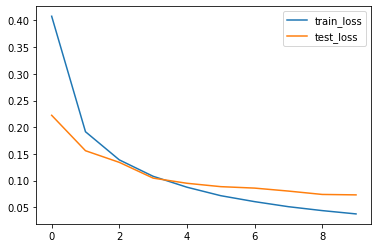

In [ ]:
plt.plot(train_losses, label='train_loss')
plt.plot(test_losses, label='test_loss')
plt.legend()
plt.show()

# **Accuracy**

In [ ]:
def get_accuracy(is_train, loader):
  n_correct, n_total = 0, 0
  for inputs, targets in loader:
      inputs, targets = inputs.to(device), targets.to(device)
      inputs = inputs.view(-1, 784)
      outputs = model(inputs)

      _, predictions = torch.max(outputs,1) # returns max, argmax 
      n_correct += (predictions == targets).sum().item()
      n_total += targets.shape[0]

  acc = n_correct / n_total
  if is_train:
    print(f'Train accuracy : {acc:.4f}')
  else:
    print(f'Test accuracy : {acc:.4f}')

get_accuracy(True, train_loader)
get_accuracy(False, test_loader)

Train accuracy : 0.9932
Test accuracy : 0.9775


# **Confusion matrix**

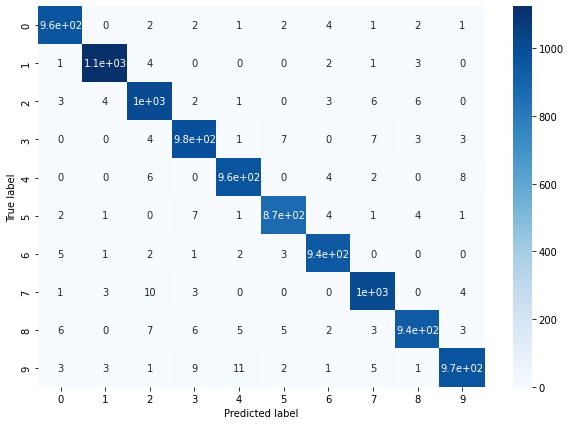

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
import seaborn as sns

X_test, y_test = test_dataset.data.numpy(), test_dataset.targets.numpy()
p_test = np.array([])

for inputs, targets in test_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    inputs = inputs.view(-1, 784)
    outputs = model(inputs)
    _, predictions = torch.max(outputs,1) 

    p_test = np.concatenate((p_test, predictions.cpu().numpy()))

cm = confusion_matrix(y_test, p_test)
plt.figure(figsize = (10,7))
sns.heatmap(cm, cmap='Blues', annot=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# **Plot misclassified samples**

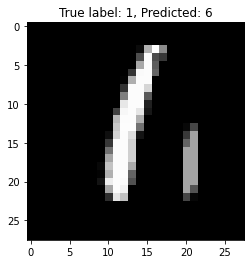

In [ ]:
misclassified_index = np.where(p_test != y_test)[0]
i = np.random.choice(misclassified_index)
plt.imshow(X_test[i], cmap='gray')
plt.title(f'True label: {y_test[i]}, Predicted: {int(p_test[i])}')
plt.show()